In [1]:
import numpy as np
import pandas as pd
import os, gc
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

## Load Dataset

<hr>

- The data comes from an Ecuador company as known as <b>Corporación Favorita</b> and it is a large grocery retailer.

- Transaction date starts from 2013-01-01 and finishes in 2017-08-31. There are 54 stores and 33 category product. 

- You can download this dataset from [Kaggle here](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

In [2]:
train_df = pd.read_csv("./train.csv", parse_dates=['date'])
test_df = pd.read_csv("./test.csv", parse_dates=['date'])
stores_df = pd.read_csv("./stores.csv")
sub_df = pd.read_csv("./sample_submission.csv")   
holidays_event_df = pd.read_csv('holidays_events.csv')
oil_df = pd.read_csv('oil.csv', parse_dates=['date'])
# transactions_df = pd.read_csv("./transactions.csv", parse_dates=['date']).sort_values(["store_nbr", "date"])

print('train shape:', train_df.shape)
print('test shape:', test_df.shape)
print('stores shape:', stores_df.shape)
print('holiday shape:', holidays_event_df.shape)

train shape: (3000888, 6)
test shape: (28512, 5)
stores shape: (54, 5)
holiday shape: (350, 6)


In [3]:
print('Train start date:', train_df['date'].dt.date.min())
print('Train end date:', train_df['date'].dt.date.max())

print('\nTest start date:', test_df['date'].dt.date.min())
print('Test end date:', test_df['date'].dt.date.max())

if (train_df.isna().sum().sum() == 0) & (test_df.isna().sum().sum() == 0):
    print('\nNo missing values in train & test')

if (train_df.duplicated().sum() == 0) & (test_df.duplicated().sum() == 0):
    print('No duplicated rows in train & test')

Train start date: 2013-01-01
Train end date: 2017-08-15

Test start date: 2017-08-16
Test end date: 2017-08-31

No missing values in train & test
No duplicated rows in train & test


# Descriptive analytics

## Sales Analysis

In [4]:
temp_df = train_df.copy()
temp_df['month'] = temp_df['date'].dt.month_name().str[:3]
temp_df['year'] = temp_df['date'].dt.year
temp_df['dayname'] = temp_df['date'].dt.day_name().str[:3]

# we only have data till August 2017
temp_df = temp_df[temp_df['date'] < '2017-01-01']

total_sales_by_month = temp_df.groupby('month')['sales'].sum()
total_sales_by_month = total_sales_by_month.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
total_sales_by_year = temp_df.groupby('year')['sales'].sum()
total_sales_by_dayofweek = temp_df.groupby('dayname')['sales'].sum()
total_sales_by_dayofweek = total_sales_by_dayofweek.reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

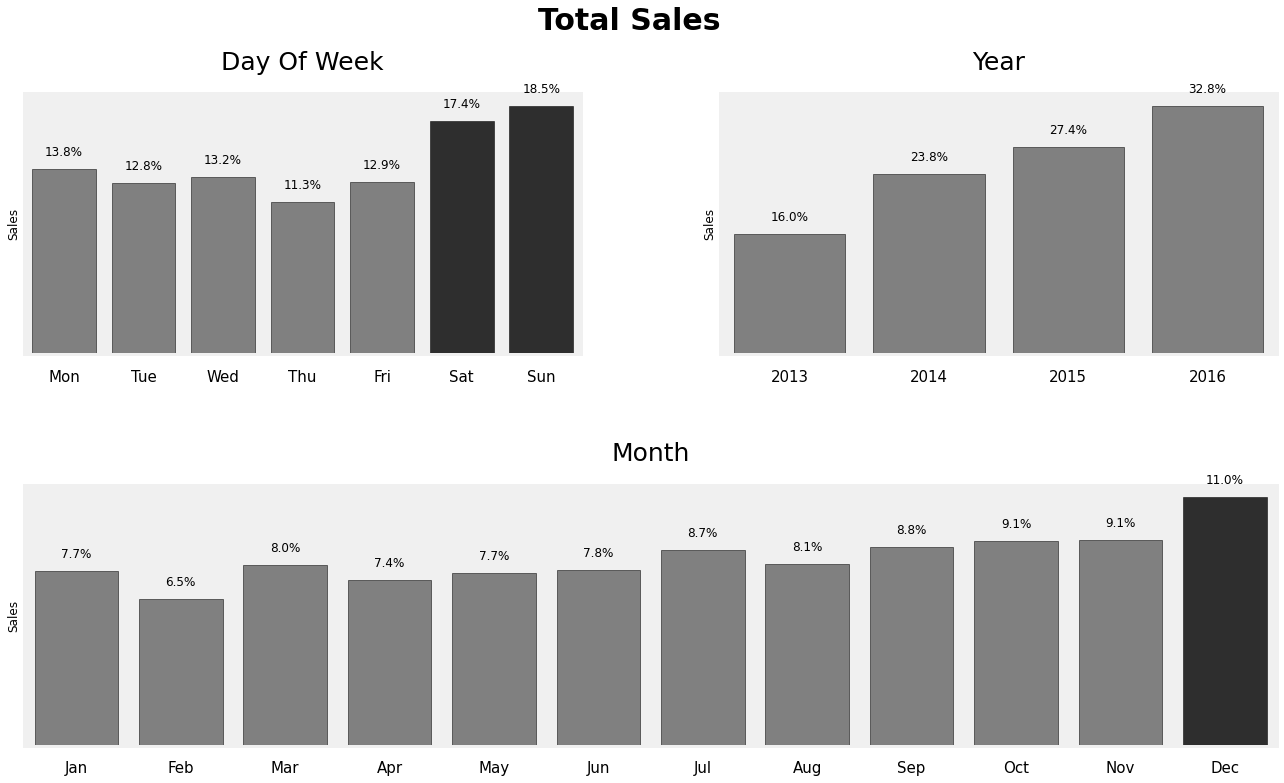

In [5]:
fig = plt.figure(figsize=(20, 12))
layout = (2,2)
axis1 = plt.subplot2grid(layout, (0,0))
axis2 = plt.subplot2grid(layout, (0,1))
axis3 = plt.subplot2grid(layout, (1,0), colspan=2)

# axis 1
ax1 = sns.barplot(total_sales_by_dayofweek.index,
                 total_sales_by_dayofweek.values,
                 color='grey',
                 edgecolor='black', ax=axis1)

for idx in range(-1, -3, -1):
    ax1.patches[idx].set_facecolor('#2E2E2E')
    
for p in ax1.patches:
    ax1.annotate(str(format(p.get_height() / total_sales_by_dayofweek.sum() * 100, '.1f')) + '%',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    fontsize=12, rotation=0, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

axis1.set_title('Day Of Week', fontsize=25, pad=24)
axis1.set_xlabel(None), axis1.set_ylabel('Sales')
axis1.set_yticks([])
axis1.tick_params(axis='x', which='major', labelsize=15, pad=15, rotation=0)

# axis 2
ax2 = sns.barplot(total_sales_by_year.index,
                 total_sales_by_year.values,
                 color='grey',
                 edgecolor='black', ax=axis2)

# ax2.patches[-1].set_facecolor('#2E2E2E')
    
for p in ax2.patches:
    ax2.annotate(str(format(p.get_height() / total_sales_by_year.sum() * 100, '.1f')) + '%',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    fontsize=12, rotation=0, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

axis2.set_title('Year', fontsize=25, pad=24)
axis2.set_xlabel(None), axis2.set_ylabel('Sales')
axis2.set_yticks([])
axis2.tick_params(axis='x', which='major', labelsize=15, pad=15, rotation=0)

plt.subplots_adjust(hspace = 0.5, wspace=.25)

# axis 3
ax3 = sns.barplot(total_sales_by_month.index,
                 total_sales_by_month.values,
                 color='grey',
                 edgecolor='black', ax=axis3)

ax3.patches[-1].set_facecolor('#2E2E2E')
    
for p in ax3.patches:
    ax3.annotate(str(format(p.get_height() / total_sales_by_month.sum() * 100, '.1f')) + '%',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    fontsize=12, rotation=0, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

axis3.set_title('Month', fontsize=25, pad=24)
axis3.set_xlabel(None), axis3.set_ylabel('Sales')
axis3.set_yticks([])
axis3.tick_params(axis='x', which='major', labelsize=15, pad=15, rotation=0)

plt.suptitle('Total Sales', fontsize=30, fontweight='bold')
plt.subplots_adjust(hspace = 0.5, wspace=.25)

### Why sales on weekends are higher than weekdays?

<div class="alert alert-success"> <b>In the old days, we had to go out for shopping (no e-commerce yet). <br><br>Many people choose to shop on the weekends simply because they don't work</b> </div>

### What makes total sales continue to increase from 2013 - 2016?

<div class="alert alert-success"> <b>Oil price is impacting the world economy, this affect costs such as transportation, manufacturing etc<br><br>I believe one of the factor why sales could increase is because the oil price was decreasing from 2013 - 2016</b> </div>

<div class="alert alert-info"> <b>We will see this pattern in the next analysis about oil price</b> </div>

### Why sales in december are higher than other months?

<div class="alert alert-success"> <b>On Christmas Eve, families enjoy the Cena de Nochebuena, which traditionally includes stuffed turkey or chicken, grapes and raisins, salads, rice with cheese, local produce, and wine or chicha<br><br>That's why people spent more product in December</b> </div>

In [6]:
food_and_beverages = ['BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'EGGS', 'GROCERY I', 'LIQUOR,WINE,BEER', 'MEATS', 'POULTRY']

temp_df = train_df[train_df['family'].isin(food_and_beverages)]
temp_df['month'] = temp_df['date'].dt.month_name()

non_december_ = temp_df[temp_df['month'] != 'December'].groupby('family')['sales'].mean().to_frame('non_december')
december_ = temp_df[temp_df['month'] == 'December'].groupby('family')['sales'].mean().to_frame('december')

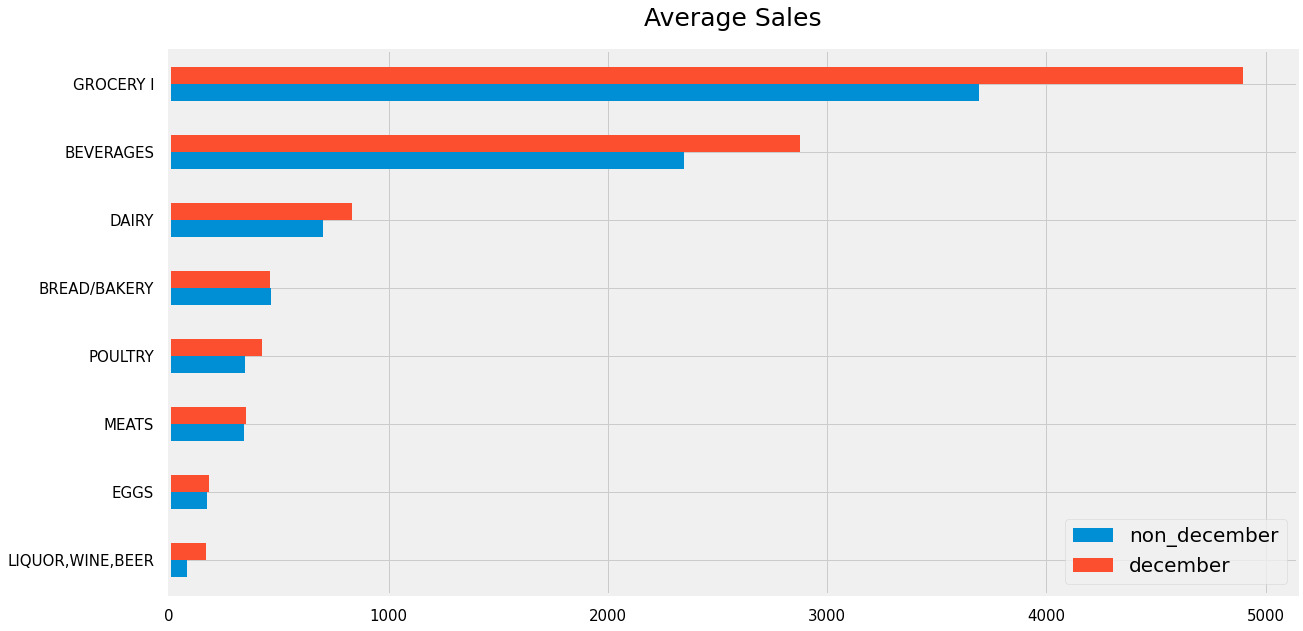

In [7]:
ax = non_december_.join(december_).sort_values(by='december').plot(kind='barh', figsize=(18,10))

ax.set_title('Average Sales', fontsize=25, pad=24)
ax.set_xlabel(None), ax.set_ylabel(None)
# ax.set_yticks([])
ax.tick_params(axis='x', which='major', labelsize=15, pad=15, rotation=0)
ax.tick_params(axis='y', which='major', labelsize=15, pad=15)
ax.legend(fontsize=20)

plt.show()

<div class="alert alert-success"> <b>Average sales is higher on December, especially for GROCERY I and BEVERAGES product</b> </div>

In [8]:
## --------------------------------------------------------------------------------------------------------------------- ##

# Is it true that the oil price has an impact on sales?

In [9]:
oil_df = oil_df.set_index("date")['dcoilwtico'].resample("D").sum().reset_index()
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].apply(lambda x: np.nan if x == 0.00 else x)
oil_df['dcoilwtico_interpolated'] = oil_df['dcoilwtico'].interpolate()
oil_df = oil_df.set_index('date')

trend_in_sales = train_df.groupby('date')['sales'].sum()

# Exponential Moving Average applies more weight to data that is more current.
trend_in_sales = trend_in_sales.ewm(30).mean()

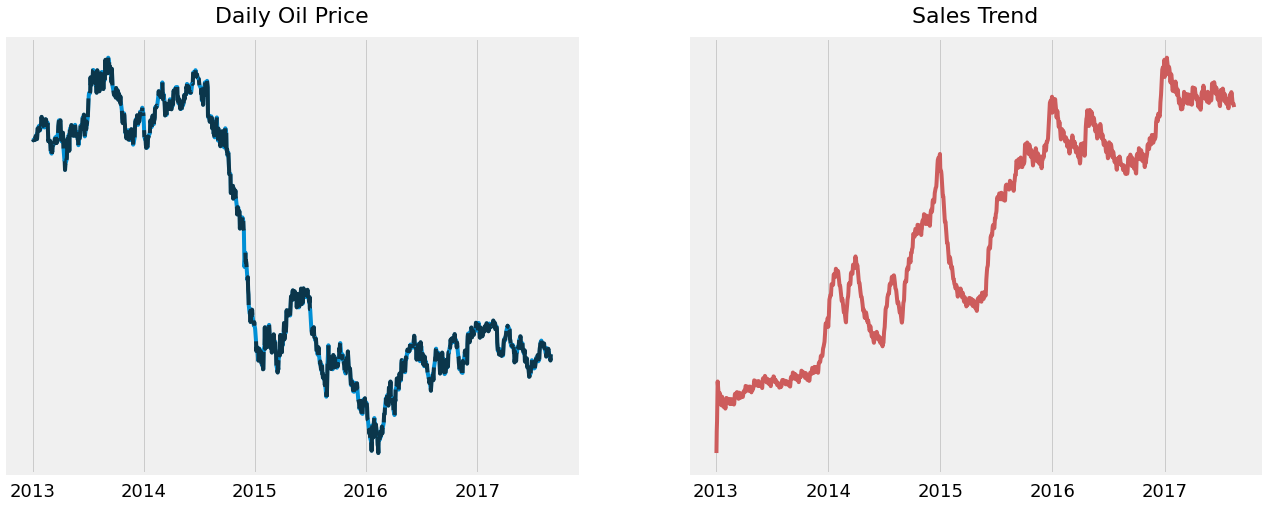

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax.ravel()[0].plot(oil_df['dcoilwtico_interpolated'])
ax.ravel()[0].plot(oil_df['dcoilwtico'], color='#111', alpha=0.7)
ax.ravel()[0].set_title('Daily Oil Price', pad=15, fontsize=22)
ax.ravel()[0].set_yticks([])
ax.ravel()[0].tick_params(axis='x', which='major', labelsize=18, pad=10)

ax.ravel()[1].plot(trend_in_sales.iloc[1:], color='indianred')
ax.ravel()[1].set_title('Sales Trend', pad=15, fontsize=22)
ax.ravel()[1].set_yticks([])
ax.ravel()[1].tick_params(axis='x', which='major', labelsize=18, pad=10)

## When daily oil price is decreasing, there are more sales in the data (vice versa)

<hr>

- Oil price increases are generally thought to <b>increase inflation</b> and <b>reduce economic growth.</b>

- This directly affect the prices of goods made with petroleum products

- Also indirectly affect costs such as transportation, manufacturing etc

<div class="alert alert-success"> <b>Do you know Ecuador is an oil-dependent country?<br><br>In 2020, Ecuador was the fifth-largest oil producer in South America</b> </div>

In [11]:
## --------------------------------------------------------------------------------------------------------------------- ##

## What does it really mean for two variables to be correlated?

<hr>

Correlation between two variables can be thought of as some kind of a relationship between them. i.e. when one variable’s value changes, the other one’s value changes in a predictable manner, most of the time.

<b>If oil price & sales are correlated, this means when oil price goes down, sales will go up (vice versa)</b>

In [12]:
temp_df = oil_df.join(train_df.groupby('date')['sales'].sum(), how='left')

# maximum date in train data is 2017-08-15, but oil data is 2017-08-31
temp_df = temp_df[:'2017-08-15']

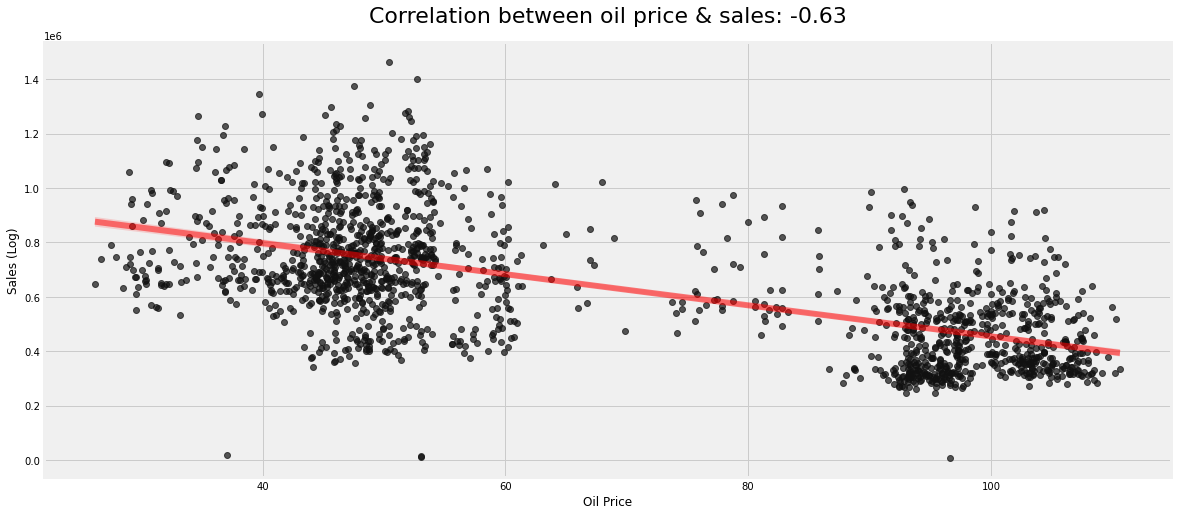

In [13]:
plt.rcParams['figure.figsize'] = [18, 8]

sns.regplot(data=temp_df, x='dcoilwtico_interpolated', y='sales',
            scatter_kws={"color": "#111", "alpha": 0.7}, line_kws={"color": "red", "alpha": 0.5}, order=1)

corr_between_oilprice_sales = temp_df.corr('pearson')['sales']['dcoilwtico_interpolated'].round(2)
plt.title(f'Correlation between oil price & sales: {corr_between_oilprice_sales}', pad=20, fontsize=22)
plt.xlabel('Oil Price'); plt.ylabel('Sales (Log)')
# plt.yticks([])

# ax.ravel()[1].set_yticks([])
# ax.ravel()[1].tick_params(axis='x', which='major', labelsize=18, pad=10)

plt.show()

- When the oil price increase then the value of sales decreases (vice versa), this is a negative correlation

- Oil price & sales values change at a constant rate with respect to each other, this known as linear correlation

- The closer the correlation to +1 / -1, the stronger it is. Correlation value -0.63 indicates the correlation is quite strong

<div class="alert alert-success"> <b>When we training machine learning model (e.g Neural Networks),<br>Variables with higher correlation with target (sales) oftentimes will have a higher weights<br><br>Higher weights variable has greater influence (more useful) over target prediction</b> </div>

In [14]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Get more deeper about correlation

<hr>

- Remember we have many product categories (e.g: grocery, meat, dairy)

- Each categories would have a different correlation with oil price

- Pearson calculation only effective if two variables have a linear correlation, for non-linear we must use other method

In [15]:
temp_df = train_df.groupby(['date', 'family'])['sales'].sum().unstack('family')
temp_df = temp_df.join(oil_df, how='left')

family_list = train_df['family'].unique().tolist()

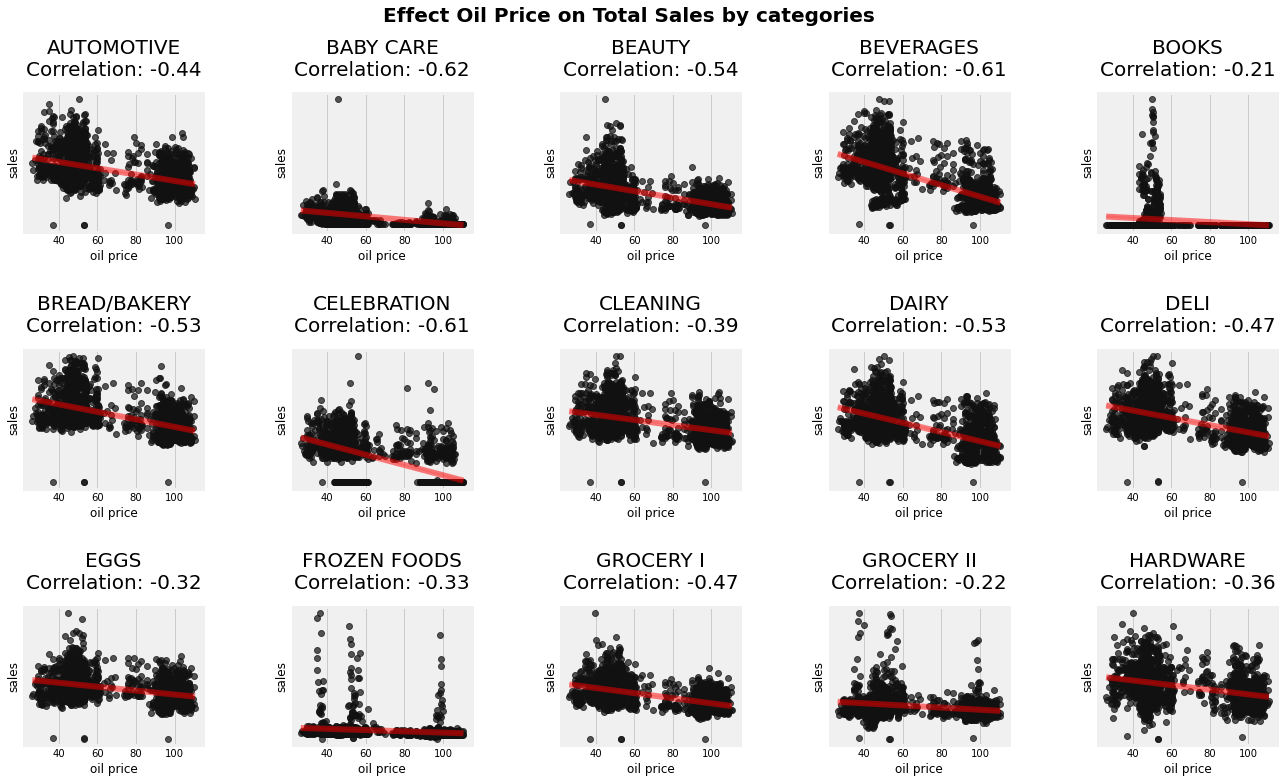

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

for idx, family in enumerate(family_list[:15]):
    
    sns.regplot(data=temp_df, x='dcoilwtico_interpolated', y=family, ax=ax.ravel()[idx],
                scatter_kws={"color": "#111", "alpha": 0.7}, line_kws={"color": "red", "alpha": 0.5})
    
    corr_ = temp_df.corr('spearman')[family]['dcoilwtico_interpolated'].round(2)
    
    ax.ravel()[idx].set_title(f'{family}\nCorrelation: {corr_}', pad=18, fontsize=20)
    ax.ravel()[idx].set_xlabel('oil price')
    ax.ravel()[idx].set_ylabel('sales')
    ax.ravel()[idx].set_yticks([])


plt.suptitle('Effect Oil Price on Total Sales by categories', fontsize=20, fontweight='bold')
plt.subplots_adjust(hspace = 0.85, wspace=.5)
plt.show()

## Remember, correlation doesn't always mean causation

<hr>

<b>Correlation</b> is simply a relationship.

On the other hand, <b>causation</b> explicitly applies to cases where action A causes outcome B

<div class="alert alert-success"> <b>To help our company business grow, we must identify what's the key items driving change in business result<br><br>Correlation cannot answer this, instead we need to do causal analysis to get the answer</b> </div>

In [17]:
## --------------------------------------------------------------------------------------------------------------------- ##

# What is Quito?

- Quito is the capital and most populous city of Ecuador, with an estimated population of 2.8 million in its urban area.

- <b>33.3% transactions</b> from this dataset are <b>from Quito</b>

- Even more, <b>51.86% from total sales</b> in dataset are <b>from Quito</b>

In [18]:
train_store = train_df.merge(stores_df, how='left', on='store_nbr')

total_sales_in_quito = train_store[train_store['city'] == 'Quito']['sales'].sum()
total_sales_in_all_data = train_store.groupby('city')['sales'].sum().sum()

print('Transactions from Quito (in percentage):', round(train_store[train_store['city'] == 'Quito'].shape[0] / train_store.shape[0] * 100, 2))
print('\nSales from Quito (in percentage):', round(total_sales_in_quito / total_sales_in_all_data * 100, 2))

Transactions from Quito (in percentage): 33.33

Sales from Quito (in percentage): 51.86


In [19]:
# filter only transaction data in Quito
quito_df = train_store[train_store['city'] == 'Quito']

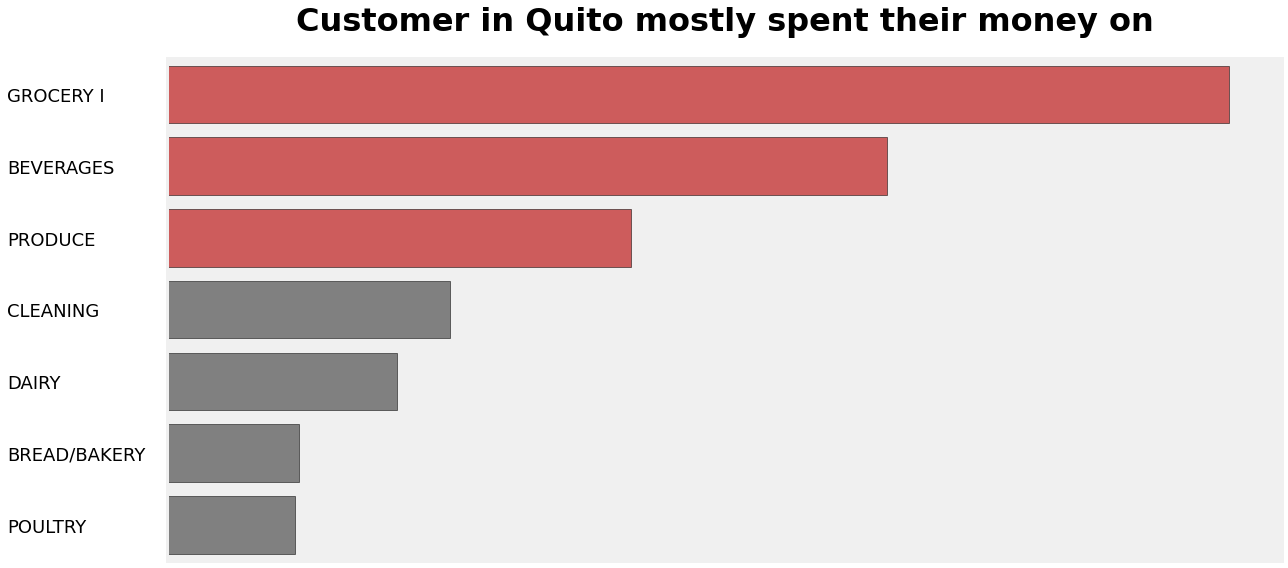

In [20]:
top_sales_in_quito = quito_df.groupby('family')['sales'].sum().sort_values(ascending=False)[:7]

ax = sns.barplot(top_sales_in_quito.values,
                 top_sales_in_quito.index,
                 color='grey',
                 edgecolor='black')

for idx in range(3):
    ax.patches[idx].set_facecolor('indianred')
    
ax.set_title('Customer in Quito mostly spent their money on', fontsize=32, fontweight='bold', pad=28)
ax.set_xlabel(None), ax.set_ylabel(None)
ax.set_xticks([])

# set left alignment
ax.set_yticklabels(top_sales_in_quito.index, ha = 'left')
plt.tick_params(axis='y', which='major', labelsize=18, pad=160)

plt.tight_layout()
plt.show()

<div class="alert alert-info"> <b>To simplified our analysis, let's use only DAIRY transaction data in store number 1</b> </div>

In [21]:
dairy_in_quito = quito_df.query("family == 'DAIRY'")
dairy_in_quito = dairy_in_quito.query("store_nbr == 1")

In [22]:
## --------------------------------------------------------------------------------------------------------------------- ##

# Time Series Forecasting in Business case

<hr>

Time series forecasting is the process of analyzing time series data using statistics and modeling to make predictions and inform strategic decision-making. 

There are multiple important areas where time series forecasting is used for example:

- Sales Forecasting
- Call Volume in a Call Center
- [Transportation e.g: Uber](https://www.uber.com/en-ID/blog/forecasting-introduction/)
- Stock market behaviour
- and many others.

In [23]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Example

<div class="alert alert-success"> <b>In e-commerce logistics case, if we can forecast how many transactions will occur in the next few days,<br><br>We'll know how many logistics-courier we need to send all packages ordered by our customer</b> </div>

<b>If we don't prepare well, many packages will get delayed especially during peak season.</b>

<b>This will give a bad experience to our customer, some of then will stop using our product and prefer to use other plattform.</b>

In [24]:
## --------------------------------------------------------------------------------------------------------------------- ##

In [25]:
dairy_in_quito = dairy_in_quito.set_index('date').asfreq('D')
dairy_in_quito['sales'] = dairy_in_quito['sales'].fillna(0)

In [26]:
import matplotlib

# plt.style.available
# plt.style.use('bmh')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

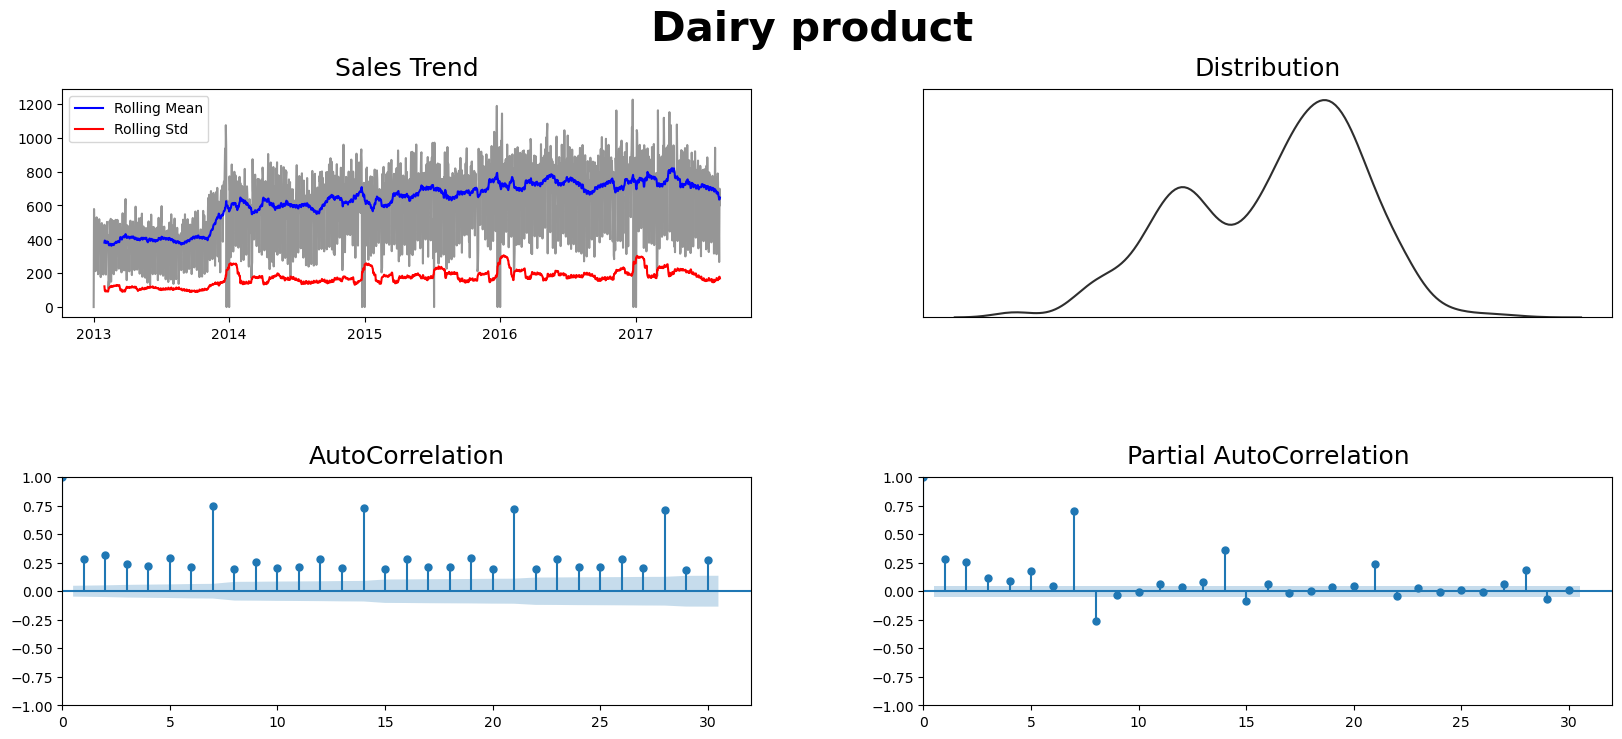

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
ax = ax.ravel()

ax[0].plot(dairy_in_quito['sales'], color='#2E2E2E', alpha=0.5)
ax[0].plot(dairy_in_quito['sales'].rolling(30).mean(), color='blue', label='Rolling Mean') # ewm - for exponential
ax[0].plot(dairy_in_quito['sales'].rolling(30).std(), color='red', label='Rolling Std')
ax[0].set_title('Sales Trend', pad=10, fontsize=18)
ax[0].legend()

sns.kdeplot(dairy_in_quito['sales'], ax=ax[1], color='#2E2E2E')
ax[1].set_title('Distribution', pad=10, fontsize=18)
ax[1].set_xlabel(None); ax[1].set_ylabel(None); ax[1].set_xticks([]); ax[1].set_yticks([])

plot_acf(dairy_in_quito['sales'], lags=30, ax=ax[2])
ax[2].set_title('AutoCorrelation', pad=10, fontsize=18)
ax[2].set_xlim(0)

plot_pacf(dairy_in_quito['sales'], lags=30, ax=ax[3])
ax[3].set_title('Partial AutoCorrelation', pad=10, fontsize=18)
ax[3].set_xlim(0)

plt.suptitle('Dairy product', fontsize=30, fontweight='bold')
plt.subplots_adjust(hspace = 0.7, wspace=.25)
plt.show()

## What information can we get from this visualization?

<hr>

- These is an upward Trend from 2013 - 2017

- 7 days Seasonal pattern (You can see in AutoCorrelation plot)

- This data does not come from a normal distribution

<div class="alert alert-info"> <b>Time series with trends, or with seasonality, are not stationary<br><br>Because the trend and seasonality will affect the value of the time series at different times</b> </div>

In [28]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Perform statistical-test to re-check Stationarity & Normality

<hr>

- Stationary: Augmented Dickey-Fuller, 

- Normality: Shapiro-Wilk, Kolmogorov-Smirnov

In [29]:
from scipy.stats import shapiro, kstest
from statsmodels.tsa.stattools import adfuller, kpss

# perform Augmented Dickey-Fuller unit-test for check stationarity
result = adfuller(dairy_in_quito['sales'])

print('Augmented Dickey-Fuller unit-test for stationarity:\n')
print('p-value:', result[1])

if result[1] < 0.05:
    print('This data is stationary')
else:
    print('This data is non-stationary')

Augmented Dickey-Fuller unit-test for stationarity:

p-value: 0.09631704881533948
This data is non-stationary


In [42]:
# perform Kwiatkowski–Phillips–Schmidt–Shin (KPSS) unit test for check stationarity

# Notes: the interpretaion of p-value for KPSS and ADF is just the opposite to each other.
# ADF: p-value < 0.05: This data is stationary
# KPSS: p-value > 0.05: This data is stationary

result = kpss(dairy_in_quito['sales'])

print('KPSS unit-test for stationarity:\n')
print('p-value:', result[1])

if result[1] > 0.05:
    print('This data is stationary')
else:
    print('This data is non-stationary')

KPSS unit-test for stationarity:

p-value: 0.01
This data is non-stationary


In [31]:
# perform Shapiro-Wilk test for normality
print('Shapiro-Wilk test for normality:')
if shapiro(dairy_in_quito['sales'])[1] < 0.05:
    print('\np-value is less than .05\nThis data does not come from a normal distribution.')

Shapiro-Wilk test for normality:

p-value is less than .05
This data does not come from a normal distribution.


In [32]:
# perform Kolmogorov-Smirnov test for normality
print('Kolmogorov-Smirnov test for normality:')
if kstest(dairy_in_quito['sales'], 'norm')[1] < 0.05:
    print('\np-value is less than .05\nThis data does not come from a normal distribution.')

Kolmogorov-Smirnov test for normality:

p-value is less than .05
This data does not come from a normal distribution.


In [33]:
## --------------------------------------------------------------------------------------------------------------------- ##

# Definitions of stationarity

<hr>

Stationarity means that the statistical properties such as mean, variance, autocorrelation, do not change over time

In other words, stationary data has:

- <b>Constant mean</b>
- <b>Constant variance</b>
- <b>Autocovariance does not depend on time</b>


<img src="https://miro.medium.com/max/945/1*tkx0_wwQ2JT7pSlTeg4yzg.png" alt="Stationarity" width="960" align="left">

source: [medium](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

In [34]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Use Differencing to handle non-stationary data

<hr>

- Differencing is performed by subtracting the previous observation from the current observation.

- Formula: <b>difference(t) = observation(t) - observation(t-1)</b>

- For time series with a seasonal component, the lag may be expected to be the period (width) of the seasonality.

<div class="alert alert-info"> <b>Differencing can help stabilise the mean of a time series by removing changes in the level of a time series.<br><br>Therefore this method can eliminating (or reducing) Trend and Seasonality.</b> </div>

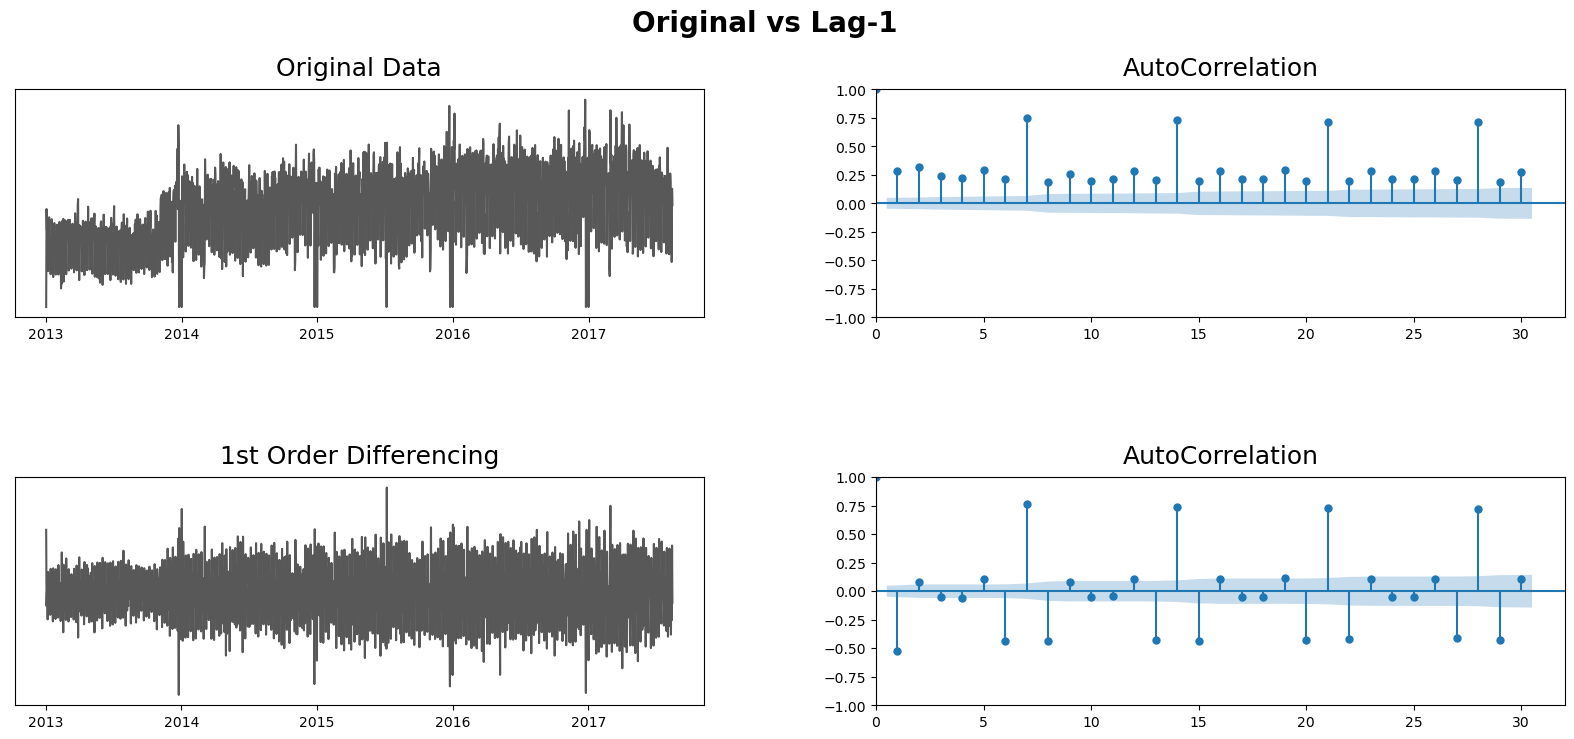

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
ax = ax.ravel()

ax[0].plot(dairy_in_quito['sales'], color='#2E2E2E', alpha=0.8)
ax[0].set_title('Original Data', pad=10, fontsize=18)
ax[0].set_yticks([])

plot_acf(dairy_in_quito['sales'], lags=30, ax=ax[1])
ax[1].set_title('AutoCorrelation', pad=10, fontsize=18)
ax[1].set_xlim(0)

# dairy_in_quito['sales'] - dairy_in_quito['sales'].shift()
ax[2].plot(dairy_in_quito['sales'].diff().dropna(), color='#2E2E2E', alpha=0.8)
ax[2].set_title('1st Order Differencing', pad=10, fontsize=18)
ax[2].set_yticks([])

plot_acf(dairy_in_quito['sales'].diff().dropna(), lags=30, ax=ax[3])
ax[3].set_title('AutoCorrelation', pad=10, fontsize=18)
ax[3].set_xlim(0)

plt.suptitle('Original vs Lag-1', fontsize=20, fontweight='bold')
plt.subplots_adjust(hspace = 0.7, wspace=.25)
plt.show()

In [36]:
# perform Augmented Dickey-Fuller unit-test for check stationarity
result = adfuller(dairy_in_quito['sales'].diff().dropna())

print('Augmented Dickey-Fuller unit-test for stationarity:\n')
print('p-value:', result[1])

if result[1] < 0.05:
    print('This data is stationary')
else:
    print('This data is non-stationary')

Augmented Dickey-Fuller unit-test for stationarity:

p-value: 6.764593181308811e-25
This data is stationary


## Notes:

<hr>

- However, the ACF of the 1st order differencing goes into the negative zone very quick.

- This can indicates that our data might have been over differenced. 

<div class="alert alert-info"> <b>The problem of over-differencing is investigated and found to be accountable for the loss of valuable information
of the time series</b> </div>

In [37]:
#################################################################################################################
##########################################  Machine Learning Model  #############################################
#################################################################################################################

# Forecasting using Facebook Prophet

<hr>

- Prophet works best with time series that have strong seasonal effects and several seasons of historical data.

- Our dataset have strong seasonalities (weekly, yearly), and they are not stationary. In this case, Prophet is an appropriate choice.

- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

<div class="alert alert-success"> <b>If the project deadline is very tight, Prophet would become my first choice to build a baseline model</b> </div>

In [38]:
import logging
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet

logging.getLogger('prophet').setLevel(logging.WARNING)

FORECAST_PERIOD = 30

tscv = TimeSeriesSplit(n_splits=3, test_size=FORECAST_PERIOD)

In [39]:
train_test_data = pd.DataFrame()

train_test_data['ds'] = dairy_in_quito.index
train_test_data['y'] = dairy_in_quito['sales'].values

# add is_wednesday and is_sunday for regressor
train_test_data['is_wednesday'] = (train_test_data['ds'].dt.day_name() == 'Wednesday').astype(int)
train_test_data['is_sunday'] = (train_test_data['ds'].dt.day_name() == 'Sunday').astype(int)

# merge with oil data
train_test_data = train_test_data.merge(oil_df[['dcoilwtico_interpolated']], how='left', left_on='ds', right_index=True)
train_test_data['dcoilwtico_interpolated'].fillna(method='bfill', inplace=True)

Fold 1 MAPE: 0.122
Fold 2 MAPE: 0.08
Fold 3 MAPE: 0.115

Average MAPE: 0.105


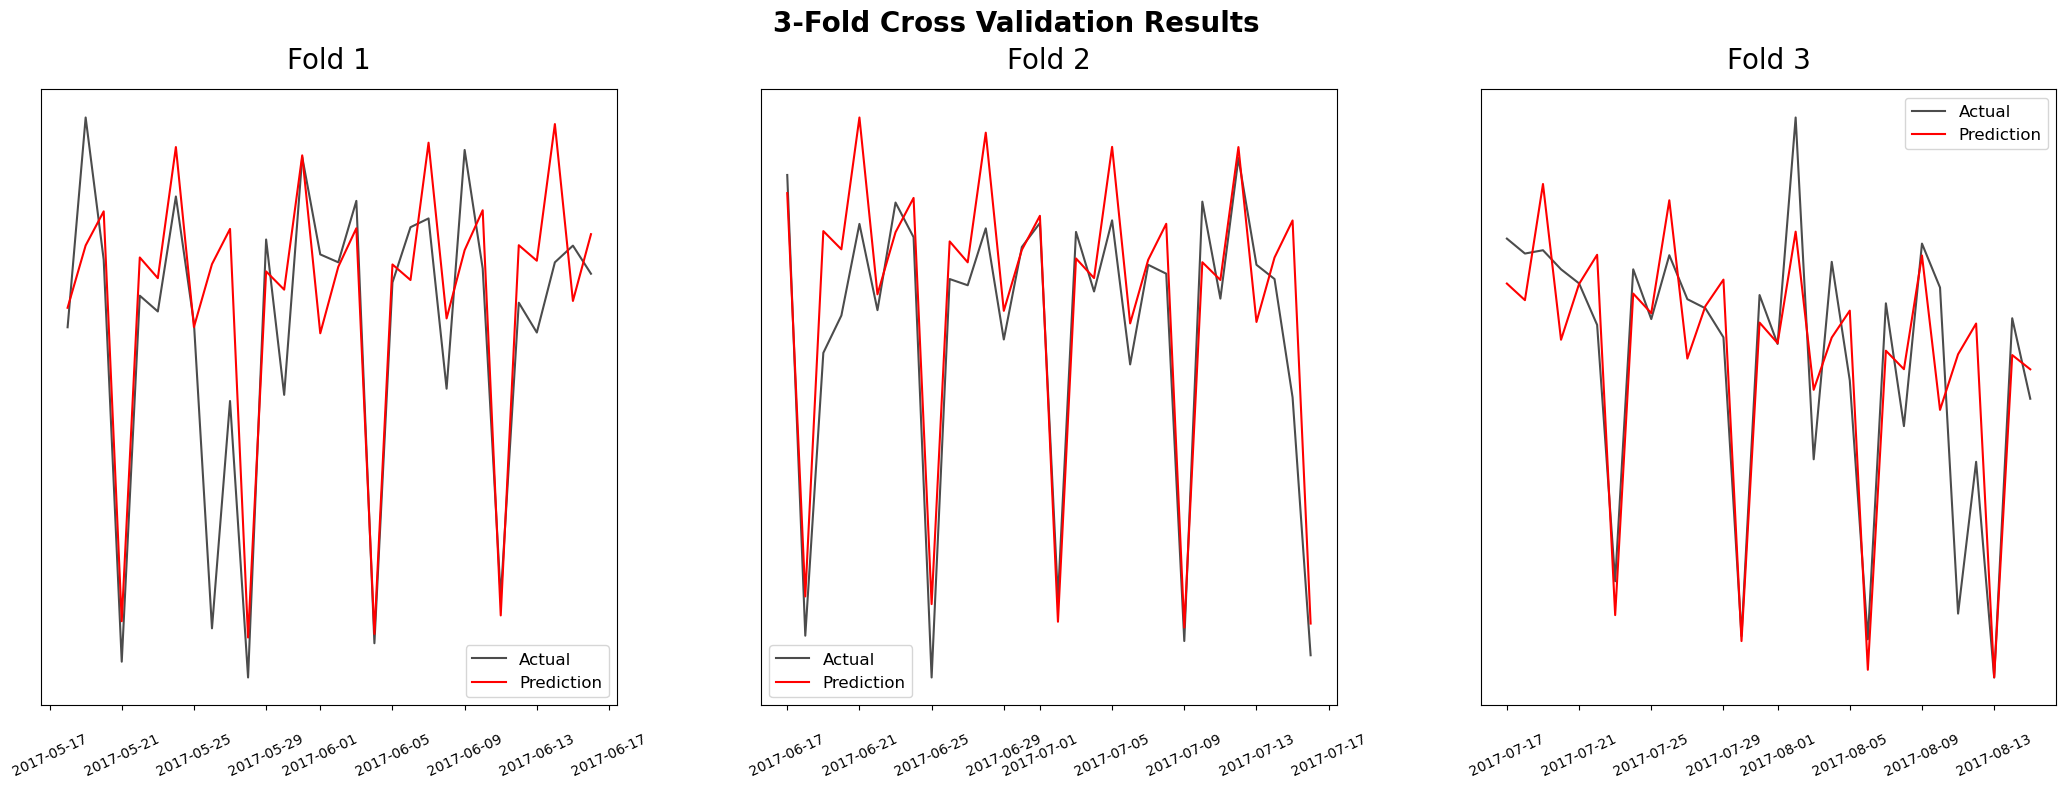

In [40]:
score_ = []

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 8))

for idx_fold, (train_idx, val_idx) in enumerate(tscv.split(train_test_data)):
    train = train_test_data.iloc[train_idx]
    test = train_test_data.iloc[val_idx]
    
    # initiate a Prophet model
    prophet = Prophet(daily_seasonality=True,
                      # holidays=holidays,
                      changepoint_prior_scale=0.15,
                      seasonality_mode='multiplicative', # additive
                      interval_width=0.85,
                      changepoint_range=0.9)

    prophet.add_regressor('is_wednesday', mode='multiplicative') # additive
    prophet.add_regressor('is_sunday', mode='multiplicative') # additive
    prophet.add_regressor('dcoilwtico_interpolated', mode='multiplicative') # additive
    
    prophet.fit(train)
    pred = prophet.predict(test)['yhat']
    mape_score = mean_absolute_percentage_error(test['y'], pred) # the lower the MAPE, better fit is the model.
    score_.append(mape_score)
    
    ax[idx_fold].plot(test['ds'], test['y'], color='black', alpha=0.7, label='actual')
    ax[idx_fold].plot(test['ds'], pred, color='red', label='prediction')

    ax[idx_fold].set_title(f'Fold {idx_fold + 1}', pad=15, fontsize=20)
    ax[idx_fold].set_yticks([])
    ax[idx_fold].tick_params(axis='x', which='major', labelsize=10, pad=15, rotation=25)
    ax[idx_fold].legend(['Actual', 'Prediction'], fontsize='large')
    
    print(f'Fold {idx_fold + 1} MAPE:', round(np.mean(mape_score), 3))
    
    if (idx_fold + 1) == 3:
        print(f'\nAverage MAPE: {round(np.mean(score_), 3)}')
        
plt.suptitle('3-Fold Cross Validation Results', fontsize=20, fontweight='bold')
plt.subplots_adjust(wspace=.25)
plt.show()

In [ ]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Notes: This is only a baseline

<div class="alert alert-success"> <b>In real-work project, accuracy is very important<br><br>Next step we can add feature enginering, use other model e.g: ARIMA, SARIMAX, Neural Networks, Gradient Boosting etc</b> </div>

In [41]:
##################################################################################################################
##########################################  To Be Continued  #####################################################
##################################################################################################################

## Additional Notes

* A time series ${x_t}$ is said to be $\textit{strictly stationary}$ if the joint distributions $F(x_{t_1}, \dots, x_{t_n})$ and $F( x_{t_1+m}, \dots, x_{t_n +m})$ are the same, $\forall$ $t_1,  t_n$ and $m$. This is a very strong condition, too strong to be applied in practice; it implies that the distribution is unchanged for any time shift!

* A weaker and more practical stationarity condition is that of $\textit{weakly stationary}$ (or $\textit{second order stationarity}$). A time series $x_t$ is said to be $\textit{weakly stationary}$ if it is mean and variance stationary and its autocovariance $Cov(x_t,x_{t+k})$ depends only the time displacement $k$ and can be written as $\gamma(k)$. 